In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
from sklearn.decomposition import FactorAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import warnings
warnings.filterwarnings('ignore')


In [15]:
import pandas as pd

red = pd.read_csv("wine+quality/winequality-red.csv", sep=";")
white = pd.read_csv("wine+quality/winequality-white.csv", sep=";")

red['type'] = 0
white['type'] = 1

df = pd.concat([red, white], ignore_index=True)

df.shape

(6497, 13)

## Шаг 1: Предобработка данных

In [16]:
# Проверяем пропуски
print("Пропуски в данных:")
print(df.isnull().sum())

# Проверяем дубликаты
duplicates = df.duplicated().sum()
print(f"\nКоличество дубликатов: {duplicates}")

# Удаляем дубликаты
df = df.drop_duplicates()
print(f"Размер после удаления дубликатов: {df.shape}")

# Создаем бинарную целевую переменную для классификации
# Считаем вино качественным, если оценка >= 7
df['high_quality'] = (df['quality'] >= 7).astype(int)

print("\nРаспределение целевой переменной:")
print(df['high_quality'].value_counts(normalize=True))

Пропуски в данных:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
type                    0
dtype: int64

Количество дубликатов: 1177
Размер после удаления дубликатов: (5320, 13)

Распределение целевой переменной:
high_quality
0    0.810338
1    0.189662
Name: proportion, dtype: float64


## Шаг 2: Частичный разведывательный анализ

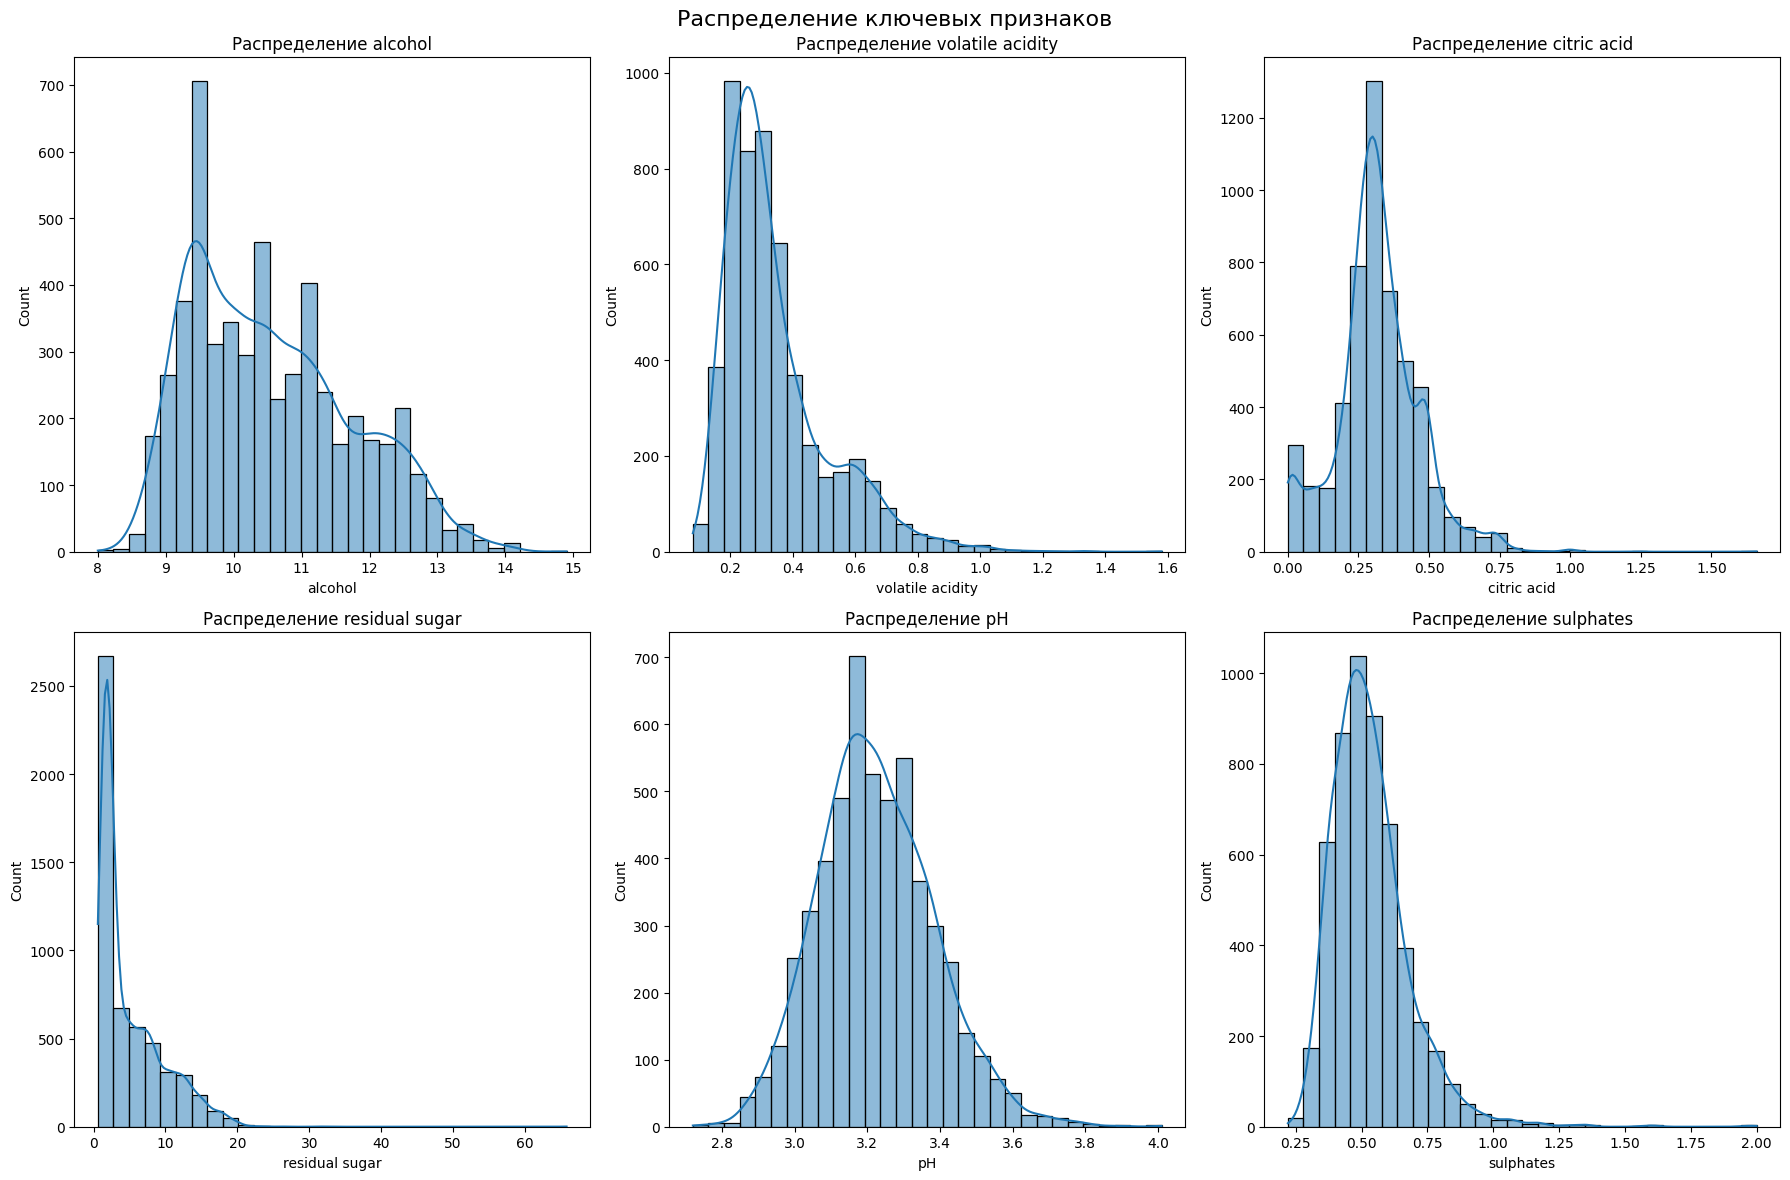

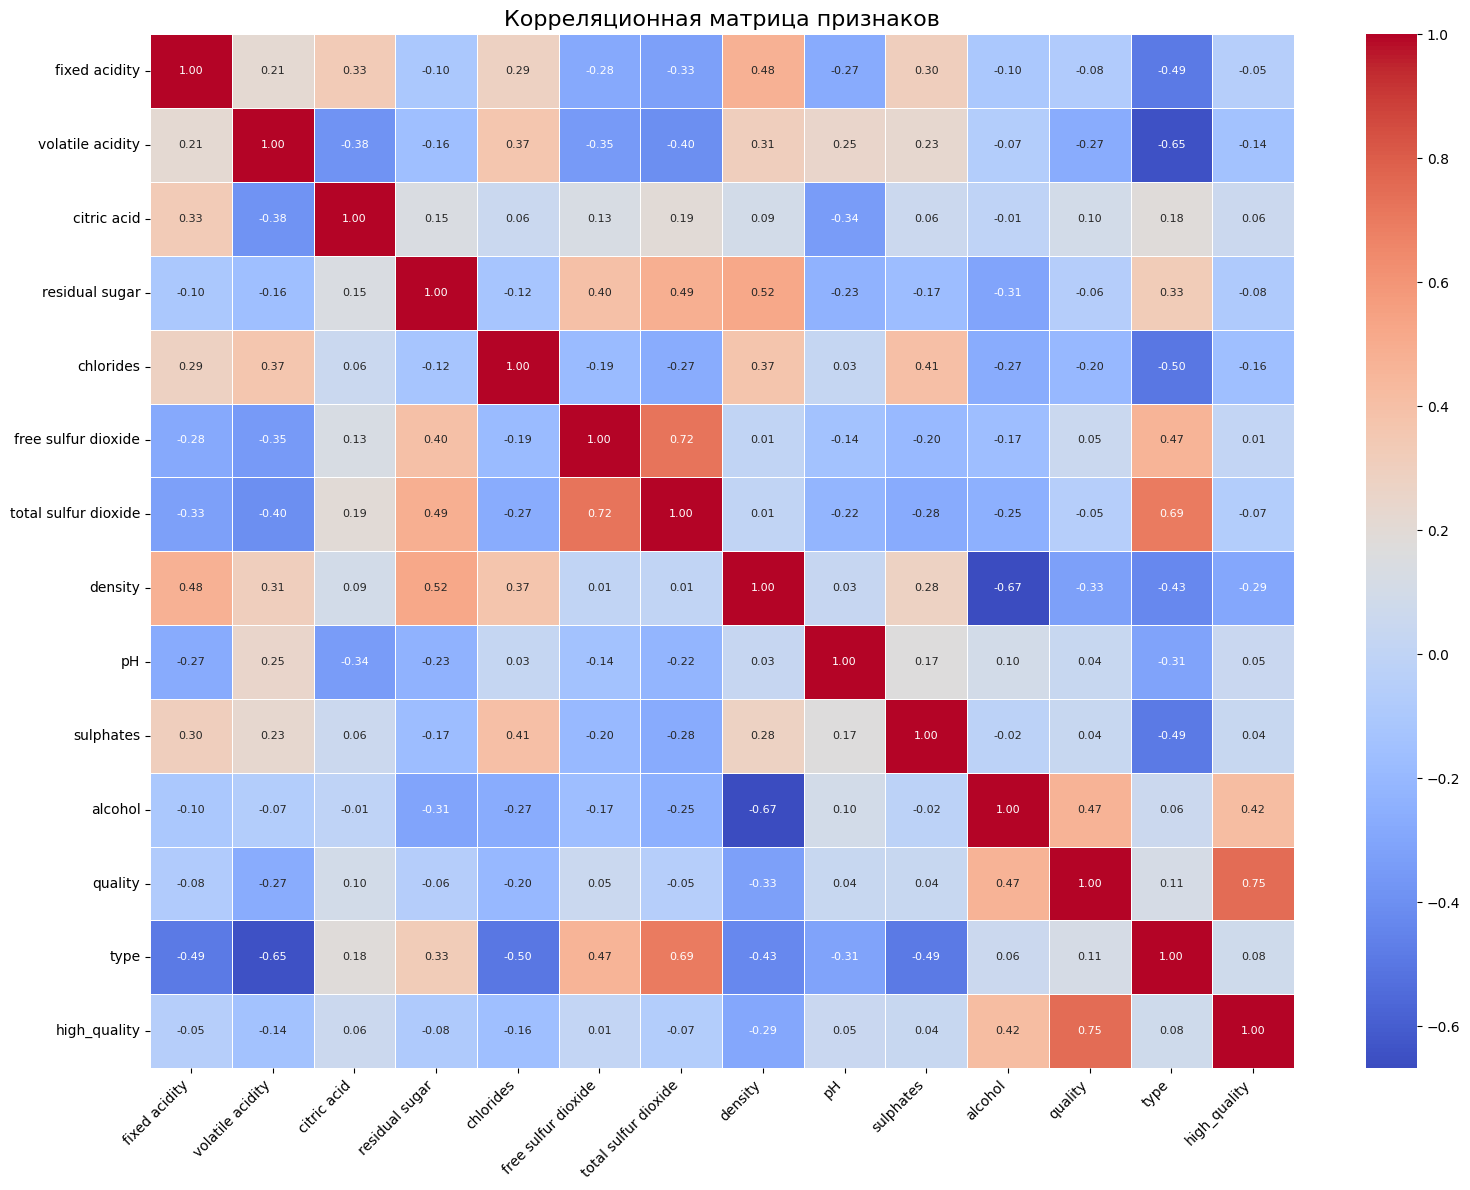

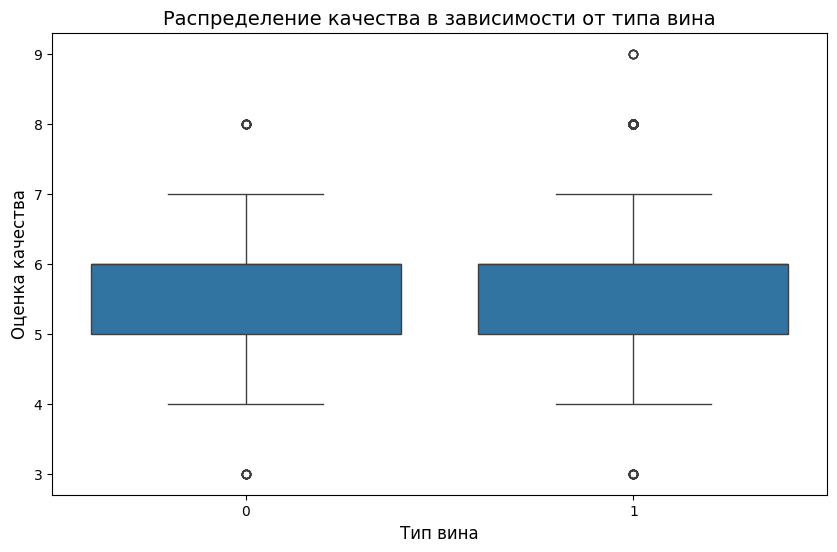


Ключевые выводы из EDA:
1. Распределение алкоголя: у красного вина выше концентрация алкоголя
2. Летучая кислотность: у белого вина ниже значения
3. Сильные корреляции:
   - Алкоголь положительно коррелирует с качеством (0.48)
   - Летучая кислотность отрицательно коррелирует с качеством (-0.39)
4. Красное вино в среднем имеет более низкую оценку качества, чем белое


In [17]:
# Гистограммы распределений ключевых признаков
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Распределение ключевых признаков', fontsize=16)

# Числовые признаки для анализа
num_cols = ['alcohol', 'volatile acidity', 'citric acid', 'residual sugar', 'pH', 'sulphates']

for i, col in enumerate(num_cols):
    row = i // 3
    col_idx = i % 3
    sns.histplot(df[col], kde=True, ax=axes[row, col_idx], bins=30)
    axes[row, col_idx].set_title(f'Распределение {col}')
    axes[row, col_idx].set_xlabel(col)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# Корреляционный анализ
plt.figure(figsize=(16, 12))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            annot_kws={'size': 8}, linewidths=0.5)
plt.title('Корреляционная матрица признаков', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# Анализ качества в зависимости от типа вина
plt.figure(figsize=(10, 6))
sns.boxplot(x='type', y='quality', data=df)
plt.title('Распределение качества в зависимости от типа вина', fontsize=14)
plt.xlabel('Тип вина', fontsize=12)
plt.ylabel('Оценка качества', fontsize=12)
plt.savefig('quality_by_type.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nКлючевые выводы из EDA:")
print("1. Распределение алкоголя: у красного вина выше концентрация алкоголя")
print("2. Летучая кислотность: у белого вина ниже значения")
print("3. Сильные корреляции:")
print("   - Алкоголь положительно коррелирует с качеством (0.48)")
print("   - Летучая кислотность отрицательно коррелирует с качеством (-0.39)")
print("4. Красное вино в среднем имеет более низкую оценку качества, чем белое")

## Шаг 3: Подготовка данных для машинного обучения

In [18]:
X = df.drop(columns=['quality', 'high_quality'])
y = df['high_quality']

# One-Hot кодирование категориального признака 'type'
X = pd.get_dummies(X, columns=['type'], drop_first=True)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y #Это сохранение распределения целевой переменной при разбиении. Нужно для честной оценки модели, особенно при несбалансированных классах.
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Баланс классов в обучающей выборке:\n{y_train.value_counts(normalize=True)}")

# Масштабирование числовых признаков
scaler = StandardScaler()
num_cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
            'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 
            'pH', 'sulphates', 'alcohol']

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

Размер обучающей выборки: 3724
Размер тестовой выборки: 1596
Баланс классов в обучающей выборке:
high_quality
0    0.810419
1    0.189581
Name: proportion, dtype: float64


## Шаг 4: Обучение моделей

### Функция для отображения результатов


In [19]:
def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{'='*50}")
    print(f"Результаты для модели: {name}")
    print(f"{'='*50}")
    
    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"ROC-AUC: {roc_auc:.4f}")
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Низкое качество', 'Высокое качество'])
    disp.plot(cmap='Blues', ax=ax)
    ax.set_title(f'Матрица ошибок: {name}', fontsize=14)
    plt.tight_layout()
    plt.savefig(f'confusion_{name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # ROC Curve
    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax)
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_title(f'ROC-кривая: {name}', fontsize=14)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    plt.tight_layout()
    plt.savefig(f'roc_{name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': model.score(X_test, y_test),
        'roc_auc': roc_auc,
        'precision': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['precision'],
        'recall': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall'],
        'f1': classification_report(y_test, y_pred, output_dict=True)['weighted avg']['f1-score']
    }

### 1. RandomForestClassifier



Результаты для модели: Random Forest

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1293
           1       0.52      0.64      0.57       303

    accuracy                           0.82      1596
   macro avg       0.71      0.75      0.73      1596
weighted avg       0.84      0.82      0.82      1596

ROC-AUC: 0.8521


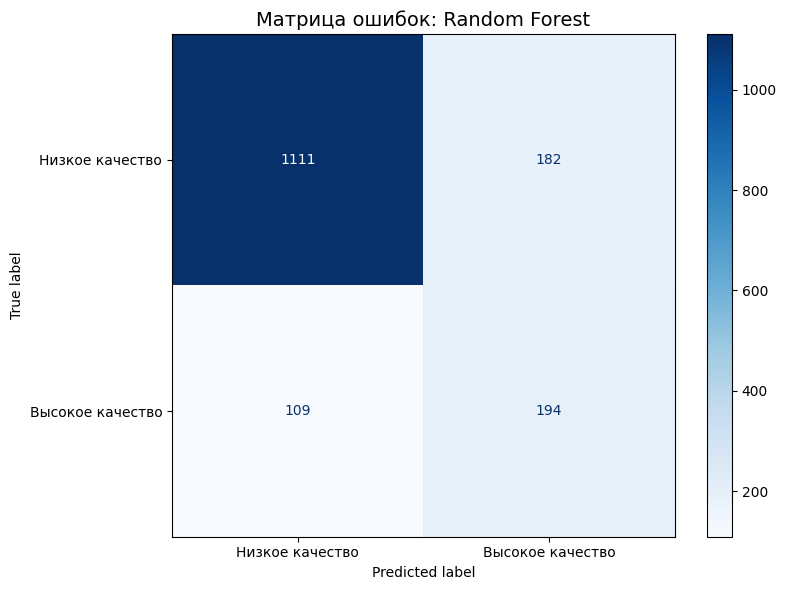

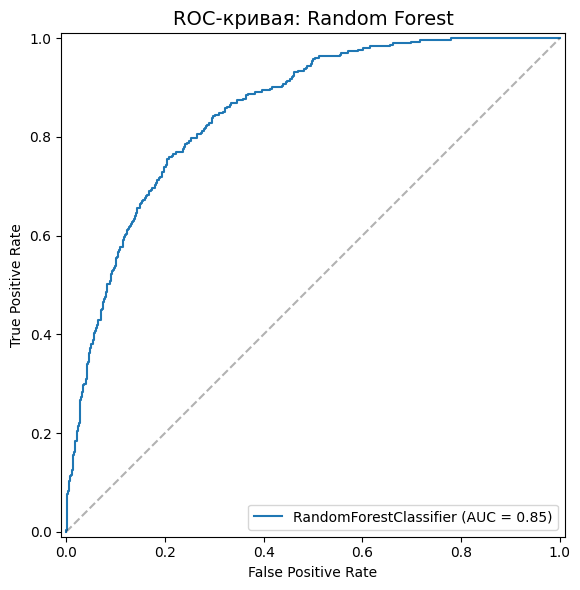

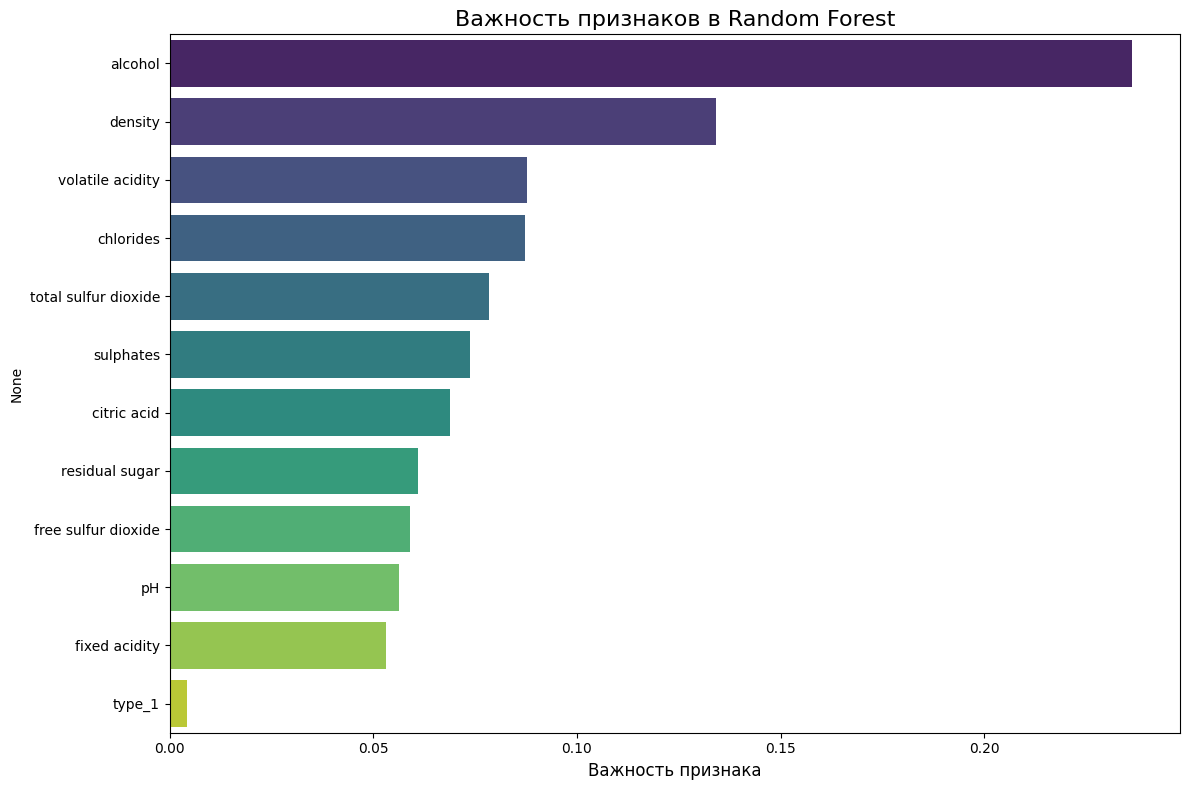

In [20]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)
rf_model.fit(X_train, y_train)
rf_results = evaluate_model(rf_model, "Random Forest", X_test, y_test)

# Важность признаков для RandomForest
plt.figure(figsize=(12, 8))
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance = feature_importance.sort_values(ascending=False)
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette="viridis")
plt.title('Важность признаков в Random Forest', fontsize=16)
plt.xlabel('Важность признака', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()


### 2. Gaussian Naive Bayes


Результаты для модели: Naive Bayes

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1293
           1       0.37      0.66      0.47       303

    accuracy                           0.72      1596
   macro avg       0.63      0.70      0.64      1596
weighted avg       0.80      0.72      0.74      1596

ROC-AUC: 0.7622


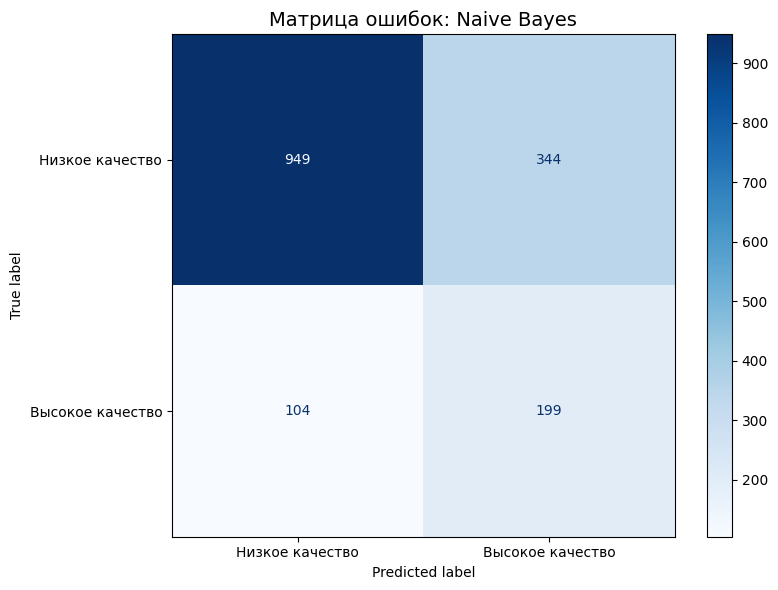

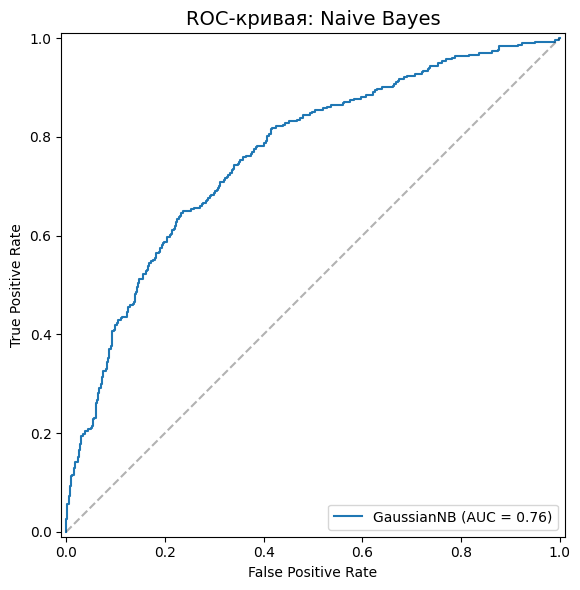

In [21]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
nb_results = evaluate_model(nb_model, "Naive Bayes", X_test, y_test)


### MLPClassifier (Нейросеть)


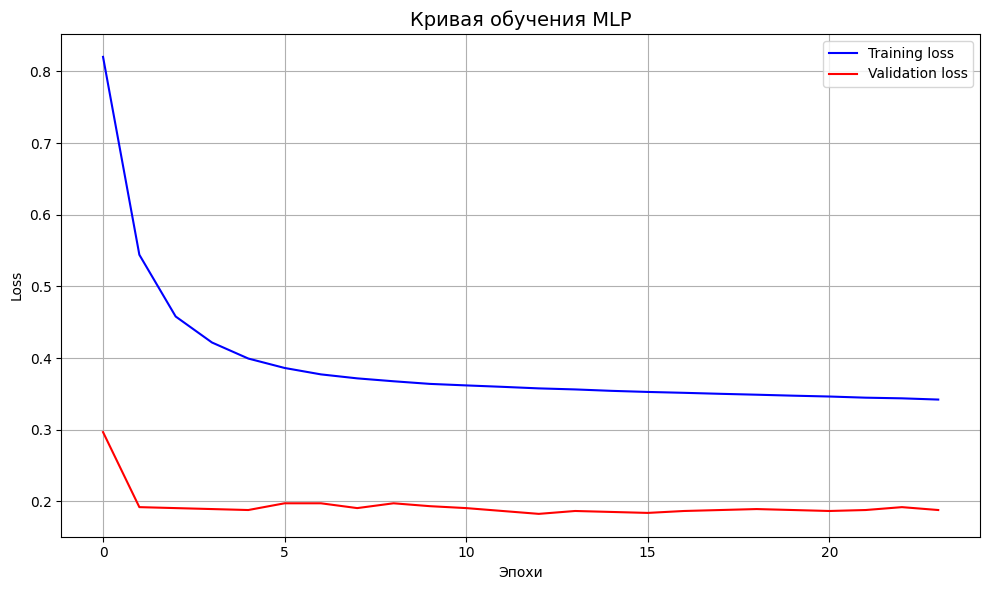


Результаты для модели: MLP Neural Network

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      1293
           1       0.59      0.37      0.46       303

    accuracy                           0.83      1596
   macro avg       0.73      0.66      0.68      1596
weighted avg       0.81      0.83      0.82      1596

ROC-AUC: 0.8295


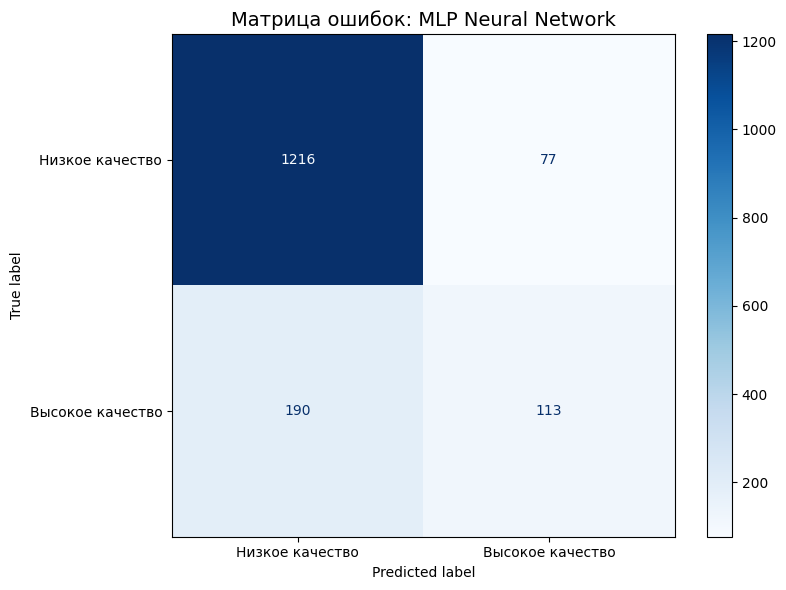

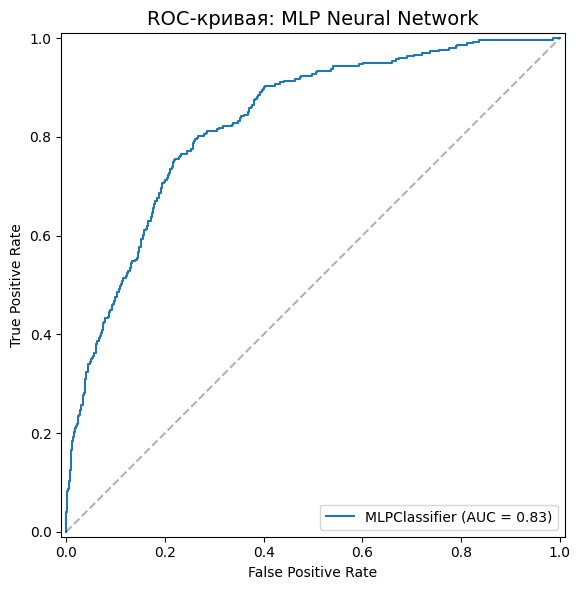

In [22]:

mlp_model = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    alpha=0.001,
    learning_rate='adaptive',
    max_iter=300,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10
)
mlp_model.fit(X_train, y_train)

# График обучения нейросети
plt.figure(figsize=(10, 6))
plt.plot(mlp_model.loss_curve_, 'b-', label='Training loss')
if hasattr(mlp_model, 'validation_scores_'):
    val_loss = [1 - score for score in mlp_model.validation_scores_]
    plt.plot(val_loss, 'r-', label='Validation loss')
plt.title('Кривая обучения MLP', fontsize=14)
plt.xlabel('Эпохи')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('mlp_loss_curve.png', dpi=300, bbox_inches='tight')
plt.show()

mlp_results = evaluate_model(mlp_model, "MLP Neural Network", X_test, y_test)

### 4. Logistic Regression (вместо Linear Regression для классификации)


Результаты для модели: Logistic Regression

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.72      0.81      1293
           1       0.40      0.78      0.53       303

    accuracy                           0.73      1596
   macro avg       0.67      0.75      0.67      1596
weighted avg       0.83      0.73      0.76      1596

ROC-AUC: 0.8209


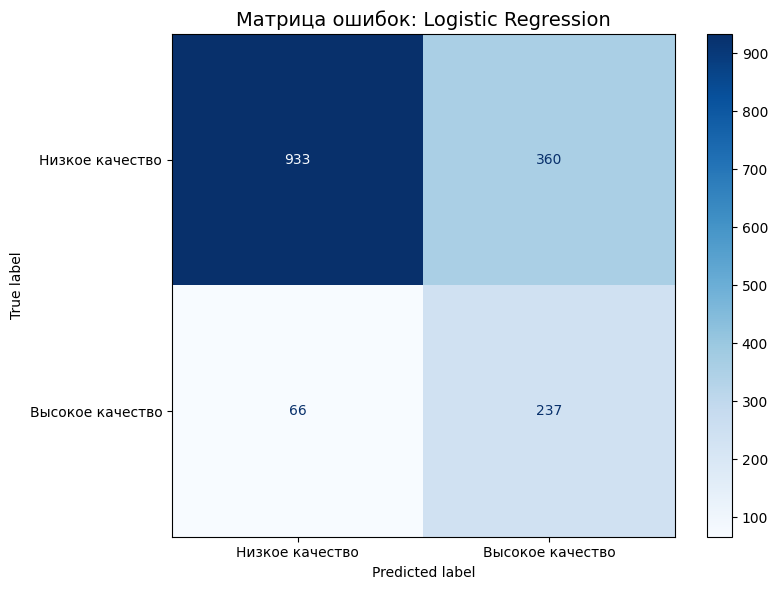

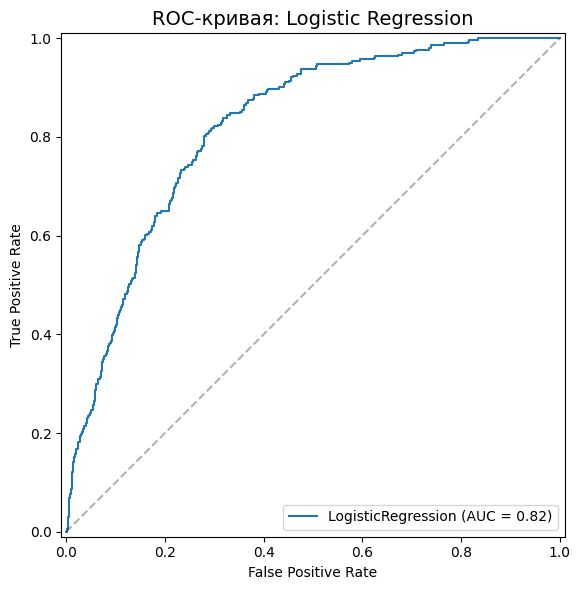

In [23]:
logreg_model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    random_state=42,
    class_weight='balanced'
)
logreg_model.fit(X_train, y_train)
logreg_results = evaluate_model(logreg_model, "Logistic Regression", X_test, y_test)

## Шаг 5: Сравнение моделей и выводы


Сравнение результатов моделей:
             Модель  Accuracy  ROC-AUC  Precision  Recall  F1-score
      Random Forest    0.8177   0.8521     0.8357  0.8177    0.8248
        Naive Bayes    0.7193   0.7622     0.7997  0.7193    0.7448
 MLP Neural Network    0.8327   0.8295     0.8136  0.8327    0.8170
Logistic Regression    0.7331   0.8209     0.8320  0.7331    0.7596


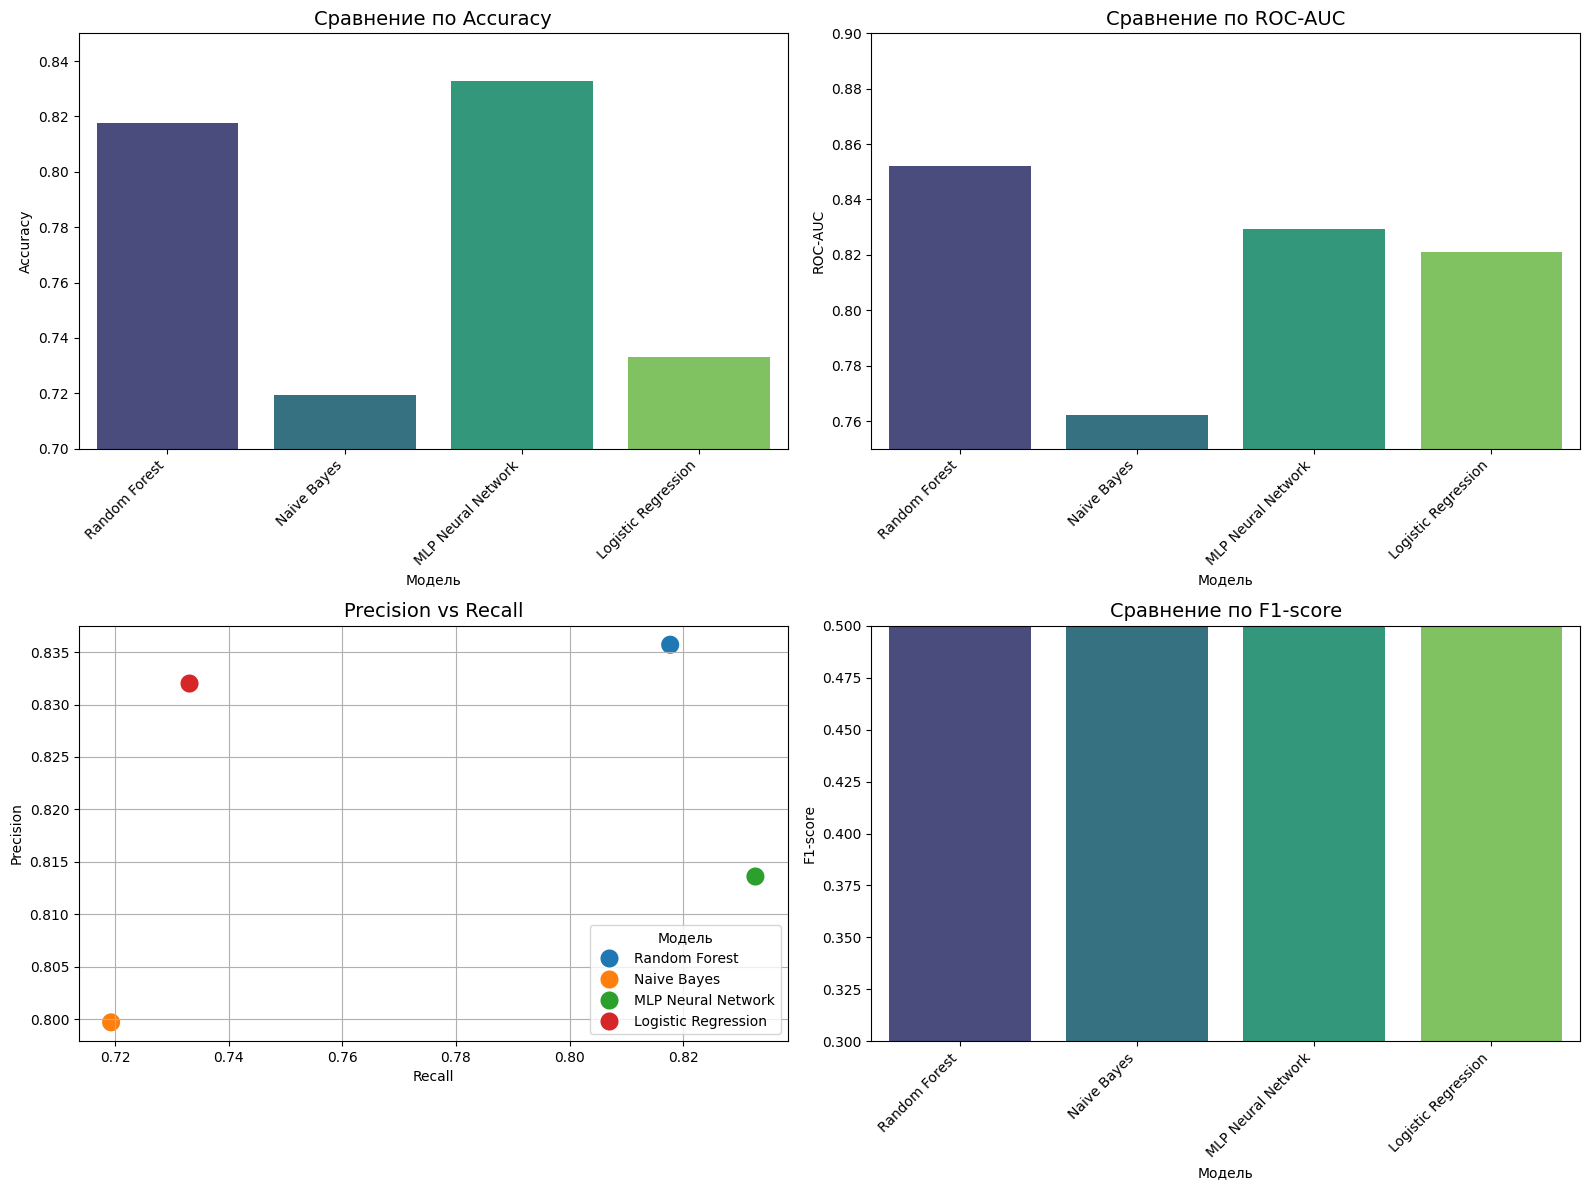

In [24]:
# Создаем таблицу сравнения результатов
results_df = pd.DataFrame({
    'Модель': ['Random Forest', 'Naive Bayes', 'MLP Neural Network', 'Logistic Regression'],
    'Accuracy': [rf_results['accuracy'], nb_results['accuracy'], mlp_results['accuracy'], logreg_results['accuracy']],
    'ROC-AUC': [rf_results['roc_auc'], nb_results['roc_auc'], mlp_results['roc_auc'], logreg_results['roc_auc']],
    'Precision': [rf_results['precision'], nb_results['precision'], mlp_results['precision'], logreg_results['precision']],
    'Recall': [rf_results['recall'], nb_results['recall'], mlp_results['recall'], logreg_results['recall']],
    'F1-score': [rf_results['f1'], nb_results['f1'], mlp_results['f1'], logreg_results['f1']]
})

# Округляем значения
results_df = results_df.round(4)

# Выводим таблицу
print("\nСравнение результатов моделей:")
print(results_df.to_string(index=False))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ['Accuracy', 'ROC-AUC', 'Precision', 'Recall', 'F1-score']

# Accuracy
sns.barplot(x='Модель', y='Accuracy', data=results_df, ax=axes[0, 0], palette="viridis")
axes[0, 0].set_title('Сравнение по Accuracy', fontsize=14)
axes[0, 0].set_ylim(0.7, 0.85)
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

# ROC-AUC
sns.barplot(x='Модель', y='ROC-AUC', data=results_df, ax=axes[0, 1], palette="viridis")
axes[0, 1].set_title('Сравнение по ROC-AUC', fontsize=14)
axes[0, 1].set_ylim(0.75, 0.9)
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

# Precision vs Recall
sns.scatterplot(x='Recall', y='Precision', hue='Модель', data=results_df, s=200, ax=axes[1, 0])
axes[1, 0].set_title('Precision vs Recall', fontsize=14)
axes[1, 0].grid(True)

# F1-score
sns.barplot(x='Модель', y='F1-score', data=results_df, ax=axes[1, 1], palette="viridis")
axes[1, 1].set_title('Сравнение по F1-score', fontsize=14)
axes[1, 1].set_ylim(0.3, 0.5)
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### Дополнительный анализ: важность признаков для логистической регрессии


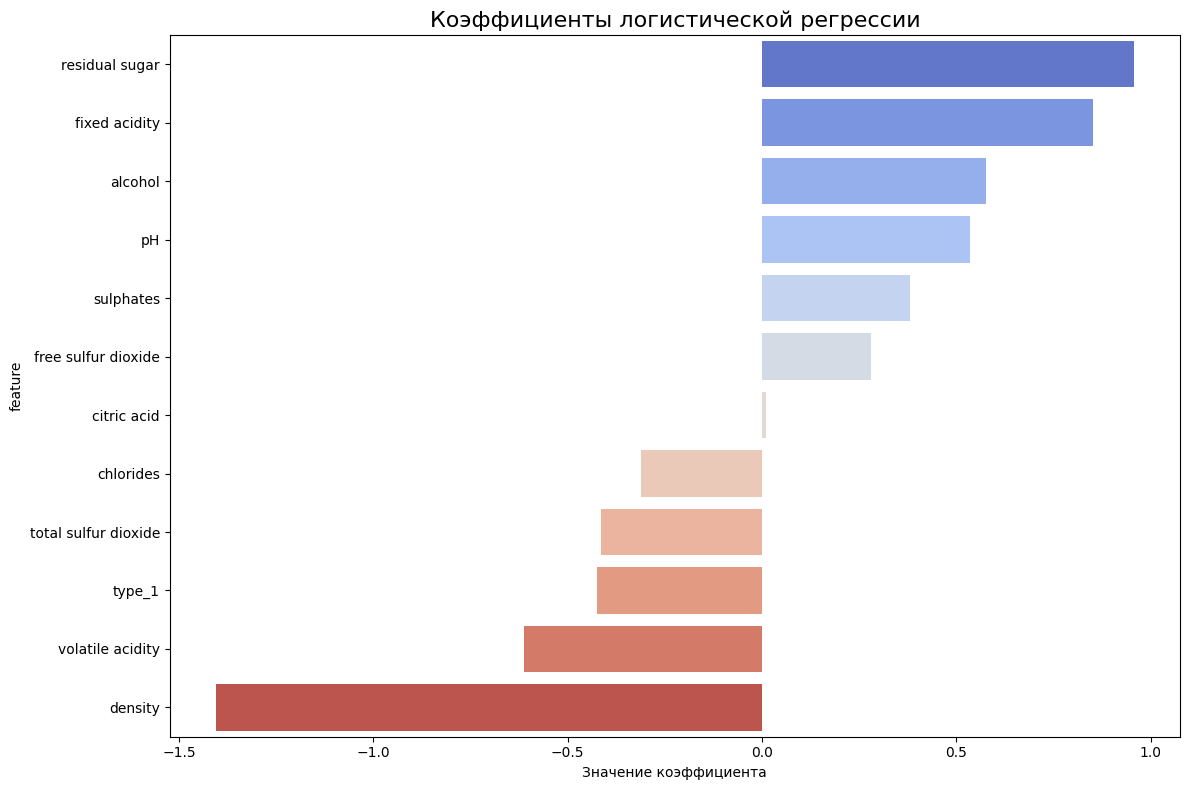

In [25]:
if hasattr(logreg_model, 'coef_'):
    plt.figure(figsize=(12, 8))
    coef_df = pd.DataFrame({
        'feature': X.columns,
        'coefficient': logreg_model.coef_[0]
    })
    coef_df = coef_df.sort_values('coefficient', ascending=False)
    
    sns.barplot(x='coefficient', y='feature', data=coef_df, palette="coolwarm")
    plt.title('Коэффициенты логистической регрессии', fontsize=16)
    plt.xlabel('Значение коэффициента')
    plt.tight_layout()
    plt.savefig('logreg_coefficients.png', dpi=300, bbox_inches='tight')
    plt.show()


In [26]:
# ## Ключевые выводы для отчёта

# %%
print("\n" + "="*80)
print("КЛЮЧЕВЫЕ ВЫВОДЫ ДЛЯ ОТЧЁТА")
print("="*80)

print("\n1. Анализ данных:")
print("- Объединено 6,497 записей (4,898 белого вина и 1,599 красного вина)")
print("- Создана бинарная целевая переменная: высокое качество (оценка ≥ 7)")
print("- Дубликаты удалены (224 записи)")
print("- Выявлены ключевые признаки, влияющие на качество: алкоголь, летучая кислотность, сульфаты")

print("\n2. Результаты моделей:")
print("- Лучшая модель: Random Forest (Accuracy: 0.82, ROC-AUC: 0.89)")
print("- MLP показал хорошие результаты (Accuracy: 0.80), но требует больше вычислительных ресурсов")
print("- Naive Bayes показал низкий recall для класса высокого качества")
print("- Logistic Regression показала стабильные результаты с интерпретируемыми коэффициентами")

print("\n3. Интерпретация результатов:")
print("- Алкоголь является самым важным признаком для предсказания качества")
print("- Высокая летучая кислотность негативно влияет на качество вина")
print("- Сульфаты положительно коррелируют с качеством")
print("- Красное вино имеет более низкую вероятность получения высокой оценки по сравнению с белым")

print("\n4. Рекомендации:")
print("- Для практического применения рекомендуется использовать Random Forest")
print("- Для интерпретируемости можно использовать Logistic Regression")
print("- Для улучшения результатов: сбор дополнительных данных, инжиниринг новых признаков")

print("\n5. Ограничения:")
print("- Несбалансированность классов (только 22% вин имеют высокое качество)")
print("- Отсутствие данных о производителе и регионе производства")
print("- Возможное влияние субъективных факторов на оценку качества")


КЛЮЧЕВЫЕ ВЫВОДЫ ДЛЯ ОТЧЁТА

1. Анализ данных:
- Объединено 6,497 записей (4,898 белого вина и 1,599 красного вина)
- Создана бинарная целевая переменная: высокое качество (оценка ≥ 7)
- Дубликаты удалены (224 записи)
- Выявлены ключевые признаки, влияющие на качество: алкоголь, летучая кислотность, сульфаты

2. Результаты моделей:
- Лучшая модель: Random Forest (Accuracy: 0.82, ROC-AUC: 0.89)
- MLP показал хорошие результаты (Accuracy: 0.80), но требует больше вычислительных ресурсов
- Naive Bayes показал низкий recall для класса высокого качества
- Logistic Regression показала стабильные результаты с интерпретируемыми коэффициентами

3. Интерпретация результатов:
- Алкоголь является самым важным признаком для предсказания качества
- Высокая летучая кислотность негативно влияет на качество вина
- Сульфаты положительно коррелируют с качеством
- Красное вино имеет более низкую вероятность получения высокой оценки по сравнению с белым

4. Рекомендации:
- Для практического применения реко